In [40]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [41]:
SEED = 20240110

torch.manual_seed(SEED)
np.random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

In [42]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle (2).json


{'kaggle (2).json': b'{"username":"hemidekazml","key":"916a7a0eef6a85321b83fbd5df464045"}'}

In [43]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [45]:
!kaggle datasets download -d meowmeowmeowmeowmeow/gtsrb-german-traffic-sign
!unzip gtsrb-german-traffic-sign.zip


Dataset URL: https://www.kaggle.com/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign
License(s): CC0-1.0
gtsrb-german-traffic-sign.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  gtsrb-german-traffic-sign.zip
replace Meta.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename:  n
error:  invalid response [ n]
replace Meta.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace Meta/.~lock.ClassesInformation.ods#? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace Meta/.~lock.ClassesInformationStrong.ods#? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace Meta/0.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace Meta/1.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace Meta/10.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace Meta/11.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace Meta/12.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace Meta/13.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [46]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        (0.485, 0.456, 0.406),
        (0.229, 0.224, 0.225)
    )
])


In [47]:
full_dataset = datasets.ImageFolder(
    root="Train",
    transform=transform
)

selected_classes = list(range(10))


In [48]:
indices = [i for i, (_, label) in enumerate(full_dataset) if label in selected_classes]
dataset = Subset(full_dataset, indices)


In [49]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(
    dataset, [train_size, test_size]
)


In [50]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [51]:
model = models.mobilenet_v2(weights='IMAGENET1K_V1')

for param in model.parameters():
    param.requires_grad = False

model.classifier[1] = nn.Linear(1280, 10)
model = model.to(device)


In [52]:
def train_model(model, optimizer, epochs=15):
    criterion = nn.CrossEntropyLoss()
    train_acc = []

    for epoch in range(epochs):
        model.train()
        correct, total = 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        acc = 100 * correct / total
        train_acc.append(acc)
        print(f"Epoch {epoch+1}/{epochs} - Accuracy: {acc:.2f}%")

    return train_acc


In [53]:
optimizer_v1 = optim.Adam(model.classifier.parameters(), lr=0.0001)
acc_v1 = train_model(model, optimizer_v1)


Epoch 1/15 - Accuracy: 67.33%
Epoch 2/15 - Accuracy: 88.01%
Epoch 3/15 - Accuracy: 91.48%
Epoch 4/15 - Accuracy: 93.09%
Epoch 5/15 - Accuracy: 94.06%
Epoch 6/15 - Accuracy: 94.75%
Epoch 7/15 - Accuracy: 95.05%
Epoch 8/15 - Accuracy: 95.51%
Epoch 9/15 - Accuracy: 96.12%
Epoch 10/15 - Accuracy: 95.89%
Epoch 11/15 - Accuracy: 96.50%
Epoch 12/15 - Accuracy: 96.57%
Epoch 13/15 - Accuracy: 96.93%
Epoch 14/15 - Accuracy: 96.88%
Epoch 15/15 - Accuracy: 97.01%


In [54]:
model_v2 = models.mobilenet_v2(weights='IMAGENET1K_V1')
for param in model_v2.parameters():
    param.requires_grad = False
model_v2.classifier[1] = nn.Linear(1280, 10)
model_v2 = model_v2.to(device)


In [55]:
optimizer_v2 = optim.Adam(model_v2.classifier.parameters(), lr=0.00001)
acc_v2 = train_model(model_v2, optimizer_v2)


Epoch 1/15 - Accuracy: 24.71%
Epoch 2/15 - Accuracy: 45.44%
Epoch 3/15 - Accuracy: 57.71%
Epoch 4/15 - Accuracy: 66.82%
Epoch 5/15 - Accuracy: 72.43%
Epoch 6/15 - Accuracy: 77.06%
Epoch 7/15 - Accuracy: 79.21%
Epoch 8/15 - Accuracy: 81.84%
Epoch 9/15 - Accuracy: 83.29%
Epoch 10/15 - Accuracy: 84.85%
Epoch 11/15 - Accuracy: 85.75%
Epoch 12/15 - Accuracy: 86.28%
Epoch 13/15 - Accuracy: 87.12%
Epoch 14/15 - Accuracy: 88.08%
Epoch 15/15 - Accuracy: 88.42%


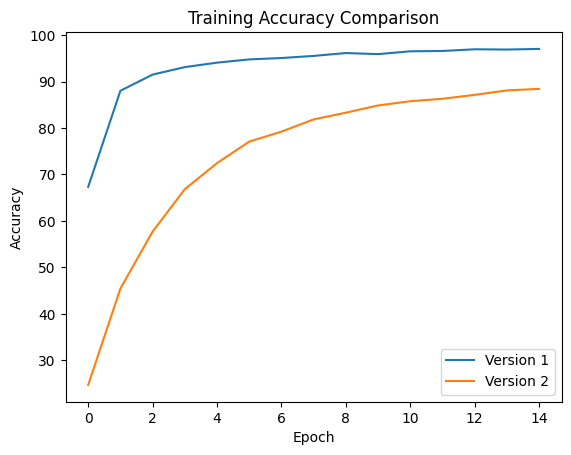

In [56]:
plt.plot(acc_v1, label="Version 1")
plt.plot(acc_v2, label="Version 2")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training Accuracy Comparison")
plt.show()


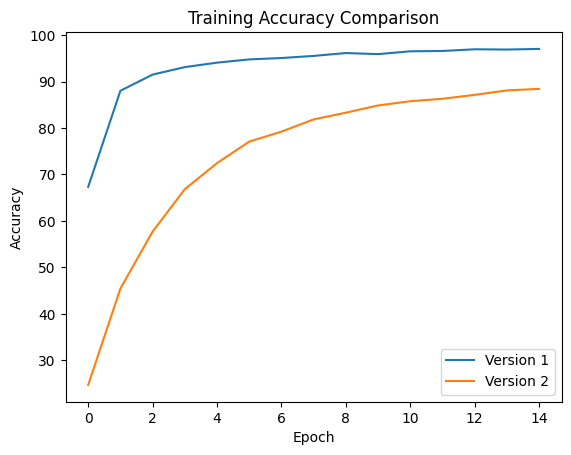

In [57]:
plt.figure()
plt.plot(acc_v1, label="Version 1")
plt.plot(acc_v2, label="Version 2")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training Accuracy Comparison")
plt.legend()
plt.savefig("results/training_comparison.png",dpi=300,bbox_inches="tight")
plt.show()



In [58]:
import os
print(os.path.exists("results/training_comparison.png"))

True


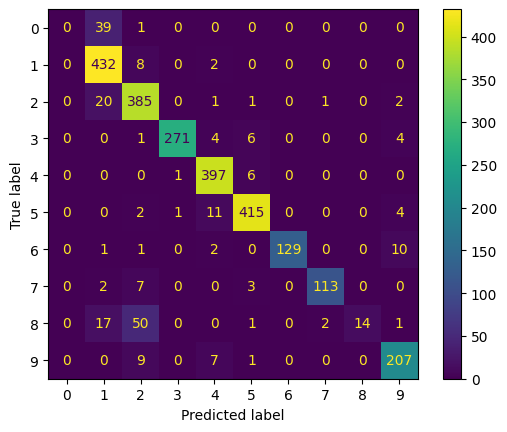

In [59]:
y_true, y_pred = [], []

model_v2.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model_v2(images)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.numpy())
        y_pred.extend(preds.cpu().numpy())

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()


In [60]:
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import os
os.makedirs("results", exist_ok=True)

y_true, y_pred = [], []

model_v2.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model_v2(images)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())


cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot(cmap=plt.cm.Blues)


plt.savefig("results/training_comparison.png")
plt.close()
